# Principal Component Analysis (PCA) and Clustering Analysis (K-means) on Pain Charts

This is an reproduction in python of the metholodogy used in the peer-reviewed article:

Boudreau, S.A., Royo, A.C., Matthews, M. et al. Distinct patterns of variation in the distribution of knee pain. Sci Rep 8, 16522 (2018). www.nature.com/articles/s41598-018-34950-2

Import of the libraries needed for preprocessing and analysis of the images

In [1]:
import pandas as pd
import sklearn
import cv2
import numpy as np
import skimage
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import glob
from PIL import Image
from sklearn.decomposition import PCA

In [2]:
# Let's import the file names from our dataset
fileNames = glob.glob(r'C:\Users\Albert\Documents\GitHub\PC data\*.png')
print('Number of files imported is',len(fileNames))

Number of files imported is 299


Pain charts are originally 3D images. However the interesting information from the images are the painted regions by the patients. So, this means that we are interested on pixels that are painted in red. For that reason, we will transform the images to a binary scale where pain (red) will be defined as 1 and the rest of the pixels as 0.

Pain charts from Navigate pain have several design errors that lead to problems when processed and manages. 
- The color painted is not a single value but a range of colors that lead to a hard binarization if one does not have access to the painting algorithm used by the app - as it is the case.
- Images from different app version have diverse dimentions and characteristics.

Let's make a example of a binarization:

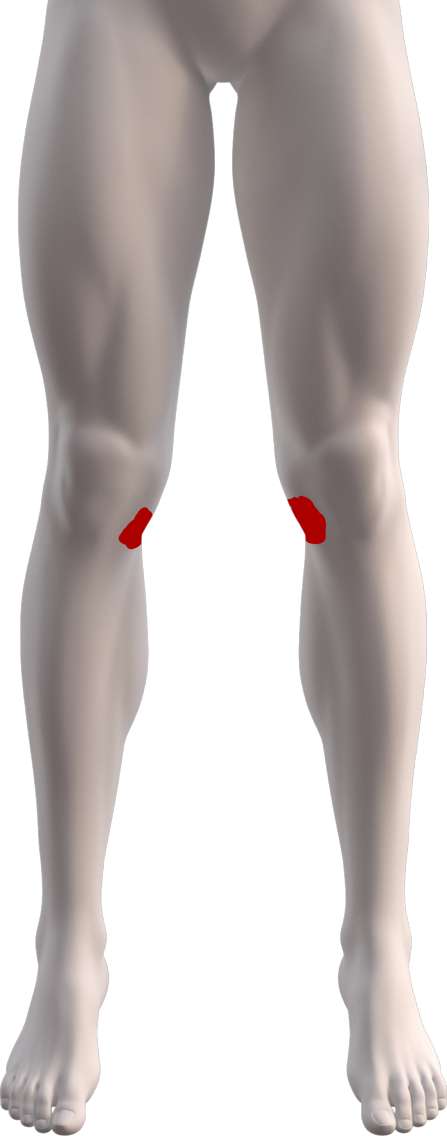

In [3]:
#Visualization of the raw image
Image.open(fileNames[1])

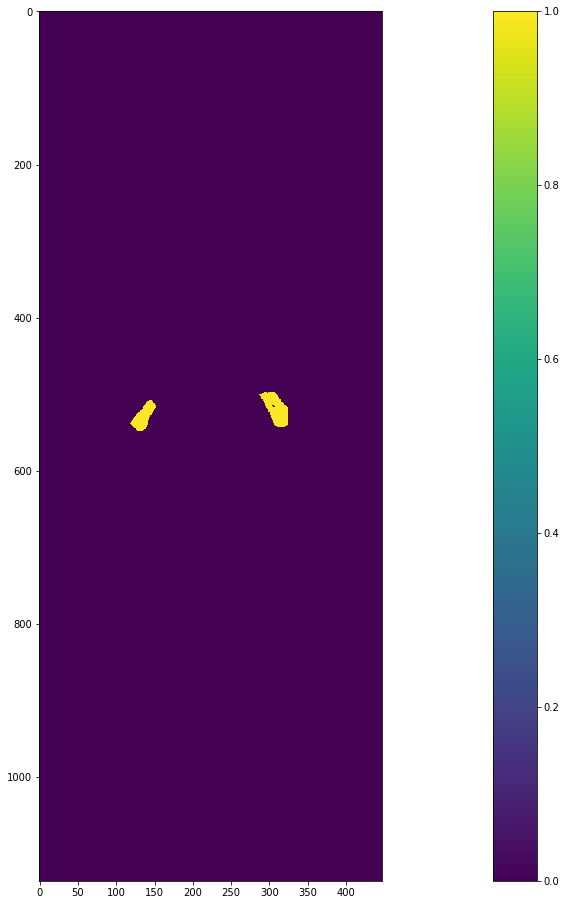

In [4]:
#Example of binarization
imExample = cv2.imread(fileNames[1])
binImExample = np.zeros(np.shape(imExample)[0:2])  #Zeros array  with the same size as the image
binImExample[(imExample[:,:,2]>150) & (imExample[:,:,0]==0)] = 1 #Activate (=1) pixels with pain drawings
plt.figure(figsize=(40,16))
plt.imshow(binImExample)
plt.colorbar()

imDataSize = np.shape(imExample)[0:2]

As you can see in the image above, on the yellow region on the right, there are some pixels (really small) which have been detected as non-pain regions but are actually artifacts. A way to delete such artifacts is to apply a morphological operation.

The morphological operations that I will apply is a erosion and then a dilation, also known as closing the image.

A 5x5 kernel with cross-shaped values is not very invasive and appropiate for this case.

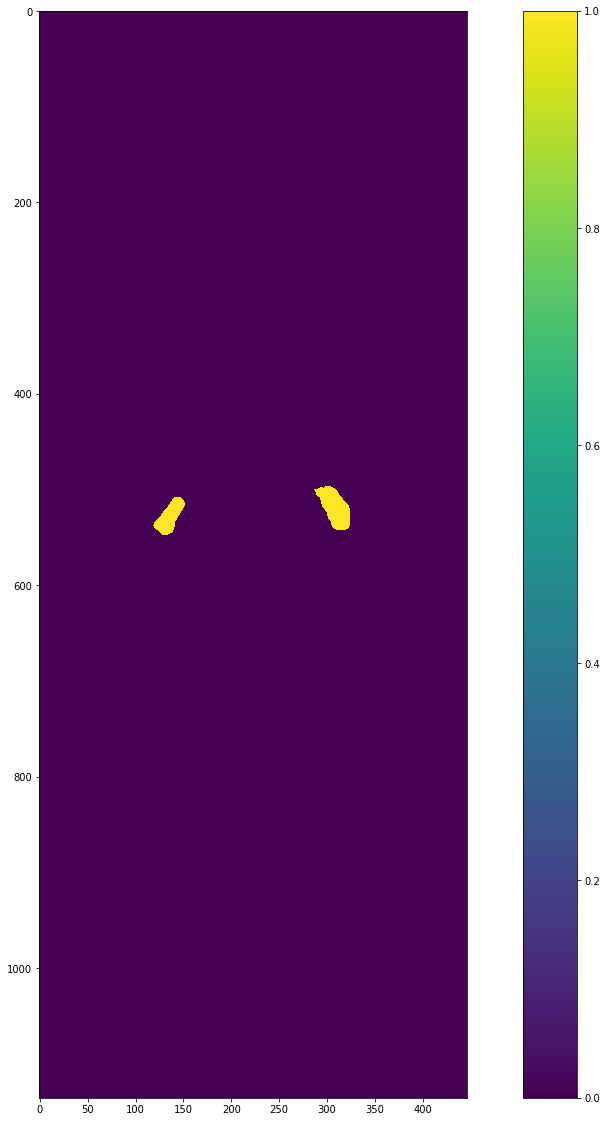

In [5]:
kernel = np.array([[0,0,1,0,0],[0,1,1,1,0],[1,1,1,1,1],[0,1,1,1,0],[0,0,1,0,0]],np.uint8)
opening = cv2.morphologyEx(binImExample, cv2.MORPH_CLOSE, kernel)
plt.figure(figsize=(20,20))
plt.imshow(opening)
plt.colorbar()

As we can see on top, the artifacts are gone and the morphology of the pain region has been almost unchanged.

Let's load all the images and preprocess them before the PCA analysis

In [6]:
kernel = np.array([[0,0,1,0,0],[0,1,1,1,0],[1,1,1,1,1],[0,1,1,1,0],[0,0,1,0,0]],np.uint8)
binIms = []
imListVect = pd.DataFrame([])   
i = 0
PainChartList = []
LabelList = []
for fileName in fileNames:
    im = cv2.imread(fileName)
    binIm = np.zeros(np.shape(im)[0:2])
    #Creating a mask from the pain Image, this will be the binarized version of the image
    binIm[(im[:,:,2]>150) & (im[:,:,0]==0)] = 1
    #Open the pain region so small empty spaces within the pain region are filled
    binIm = cv2.morphologyEx(binIm, cv2.MORPH_CLOSE, kernel)
    #Saving images and names (labels) in a List 
    PainChartList.append(binIm)
    LabelList.append(fileName)
    #Preparing the images for a PCA
    binImS = pd.Series(binIm.flatten(),name=fileName)
    imListVect = imListVect.append(binImS)

In [7]:
imListVect.shape

(299, 507792)

Now that we have the vectorized images in a List we can put them in the PC

In [8]:
pca = PCA()
pca.fit(imListVect)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [9]:
explainedVariance = pd.DataFrame(pca.explained_variance_ratio_,columns = ['Explained variance'])    
explainedVariance.head(20).round(4)*100

,Explained variance
0,14.71
1,7.80
2,6.20
3,5.20
4,3.52
5,3.27
6,2.74
7,2.13
8,1.98
9,1.76


PC selection is tricky. One can define a threshold of explained information or - since we are working with images - we can visualize principal components with more information. In this case we will define a 5% of explained information as threshold and therefore we will visualize the first 5 PC.

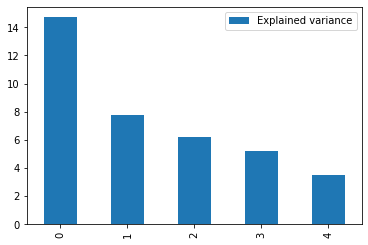

In [10]:
explained5 = explainedVariance[0:5].round(4)*100;

explained5.plot(kind='bar')


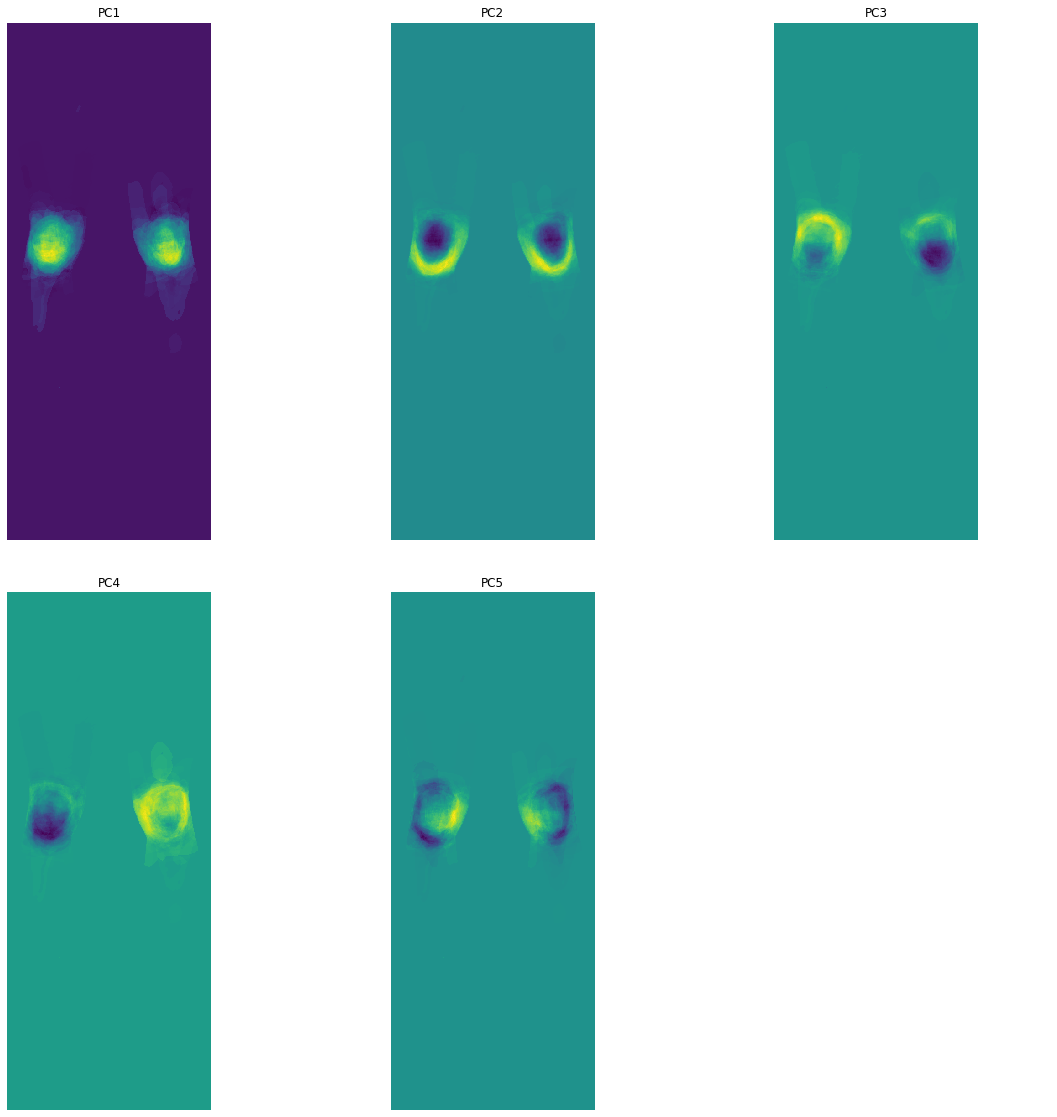

In [11]:
#function plotting several images in a subplot
def multiplePlot(data,title,alpha = 1):
    if np.size(data,0)<=3:
        numX = 1
        numY = np.size(data,0)
    else:
        numX = int(np.ceil(np.size(data,0)/3))
        numY = 3
    fig, axes = plt.subplots(numX,numY, figsize=(20, 20),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        if i<np.size(data,0):
            ax.set_title(title+'%s'%(i+1))
            ax.imshow(data[i].reshape(np.shape(im)[0:2]),alpha = alpha)
        ax.axis('off')
multiplePlot(pca.components_[0:5,],"PC")

Now we can have an idea of how look the different PC. Following the paper from Boudreu we will chose 3 PC as features for the clustering analysis. In this case we will use K-means.

In order to know the best K we can produce a ROC curve with the inter cluster distance and select the number of cluster that lays on the elbow of the ROC curve.

Let's proceed.

In [25]:
kmeans = []
interDistance = []
#first we need to calculate the coefficients/weights for each image
imNewFeat = pca.transform(imListVect)
from sklearn.cluster import k_means
for k in range(2,10):
    kmean = k_means(imNewFeat[:,0:2],n_clusters = k)
    kmeans.append(kmean)
    interDistance.append(kmean[2])

Let's produces the ROC curve for the inter distance

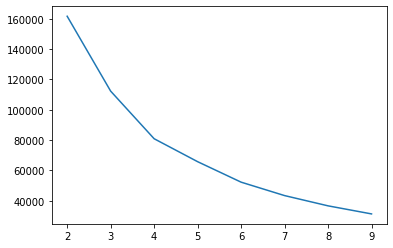

In [26]:
plt.plot(range(2,10),interDistance)

Seems that's 4 cluster would be the most adequate K

Note: Theoretically this curve should look more like a invese exponential

In [27]:
#Saving results
np.savetxt('classesK4',kmeans[2][1])

From this we can find one big cluster with other 3 smaller

How can we visualize the cluster? We can create a heatmap to find the pain morphology for each group.

In [28]:
#Image indexes for each cluster
indG1 = np.where(kmeans[2][1] == 0)
indG2 = np.where(kmeans[2][1] == 1)
indG3 = np.where(kmeans[2][1] == 2)
indG4 = np.where(kmeans[2][1] == 3)

In [29]:
#Images for each cluster
imListG1 = imListVect.iloc[indG1].to_numpy()
imListG2 = imListVect.iloc[indG2].to_numpy()
imListG3 = imListVect.iloc[indG3].to_numpy()
imListG4 = imListVect.iloc[indG4].to_numpy()
imListClusters = [imListG1,imListG2,imListG3,imListG4]

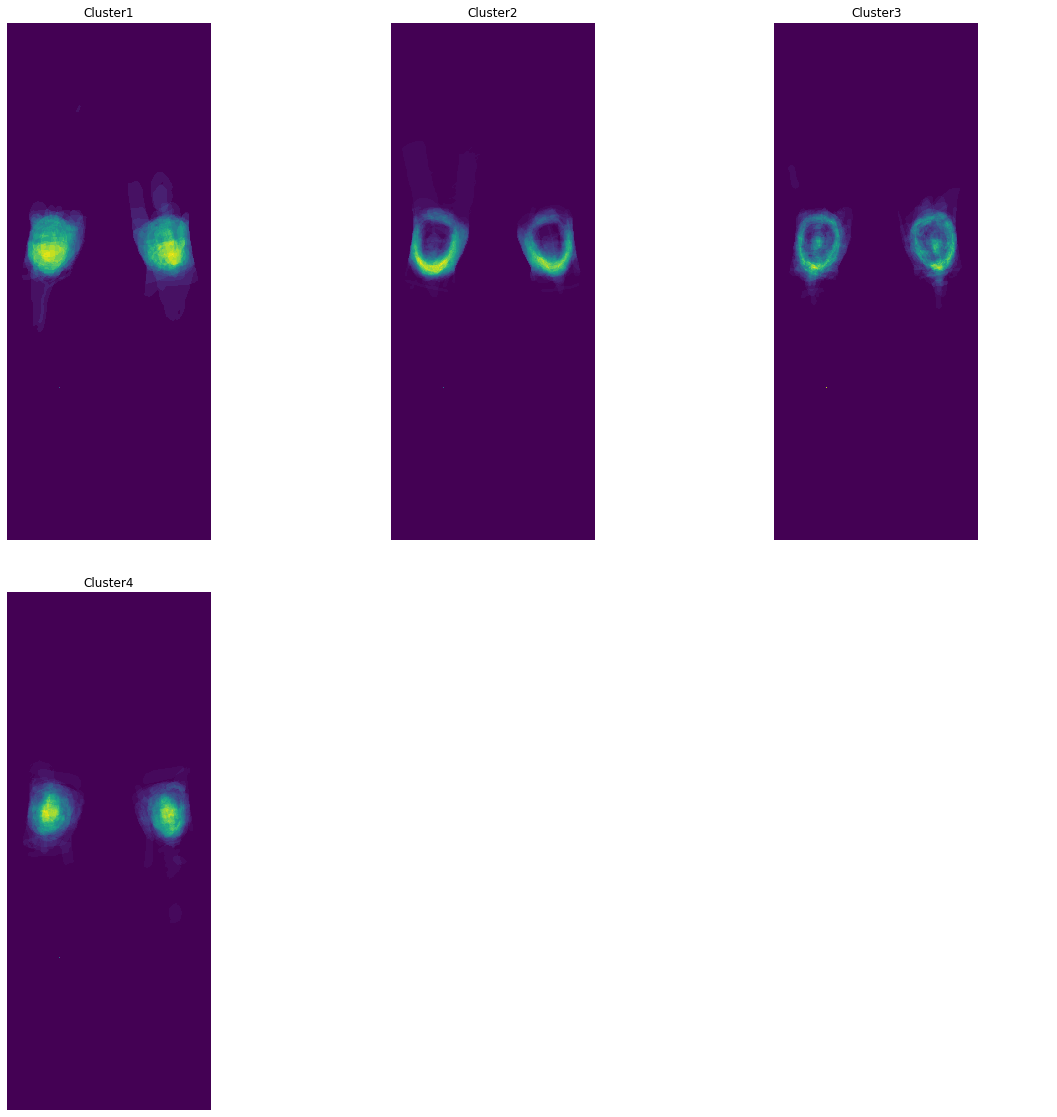

In [30]:
def overlayHotMap(imList,size):#Function that generates a hotmap
    imListReshaped = imList.sum(axis=0).reshape(size)
    return imListReshaped
Overlays = []
for clust in imListClusters:
    overlayClust = overlayHotMap(clust,imDataSize)
    Overlays.append(overlayClust)   

multiplePlot(Overlays,'Cluster')

In [31]:
# Generation of the alpha map for plotting
# Pixels with value 0 (no overlap whatsoever) will be transparent, otherwise will be opac
def alphaMatrix(Overlay):
    AlphaIm = Overlay > 0
    return AlphaIm
alphaMatrixes = []

for ov in Overlays:
    alpha = alphaMatrix(ov)
    alphaMatrixes.append(alpha)   

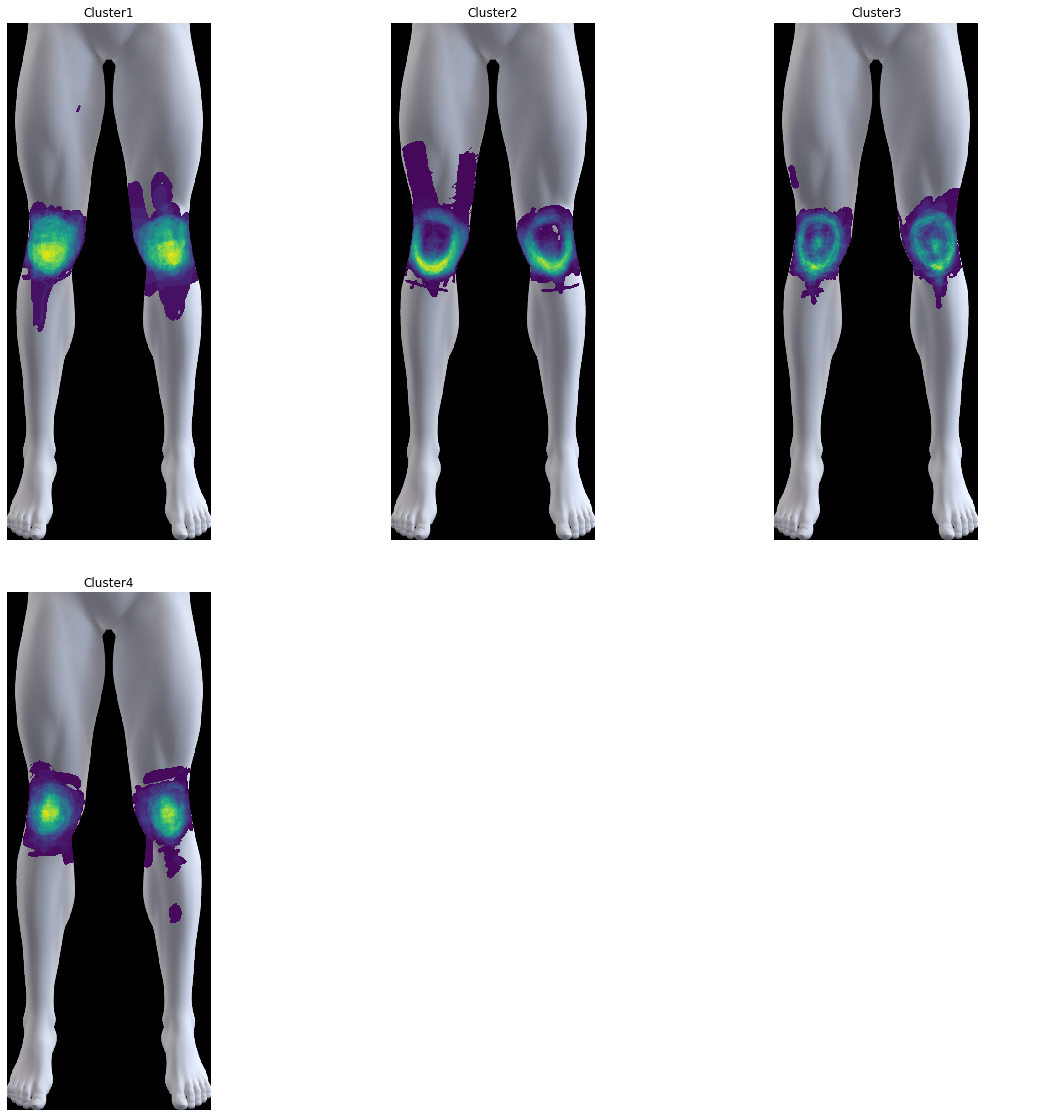

In [32]:
Background = cv2.imread('C:/Users/Albert/Documents/GitHub/backGround.png')

def plotOverlayWithBackground(title,Background,Overlays,alphaMatrixes):
    # When overlapping two images we need to define the extent of 
    # the plot so they share the location where they are overplace
    dx, dy = 0.02, 0.02
    ratioDim = imDataSize[0]/imDataSize[1]
    y = np.arange(-10.0*ratioDim,10.0*ratioDim, dx)
    x = np.arange(-10, 10, dy)
    extent = np.min(x), np.max(x), np.min(y), np.max(y)
    
    #Calclation of the number of rows of the plot for 3 plot per row
    if np.size(Overlays,0)<=3: #for cases with 3 or less plots
        numX = 1
        numY = np.size(data,0)
    else:
        numX = int(np.ceil(np.size(Overlays,0)/3))
        numY = 3
    fig, axes = plt.subplots(numX,numY, figsize=(20, 20), #Initiatlizing subplot
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1)) 
   
    for i, ax in enumerate(axes.flat):#Iterating through the axes (or subplots)
        if i<np.size(Overlays,0):
            ax.set_title(title+'%s'%(i+1))
            ax.imshow(Background,extent= extent)
            normOverlay = colors.Normalize(Overlays[i].min(),Overlays[i].max())
            img = plt.get_cmap('viridis')(normOverlay(Overlays[i]))
            img[..., 3] = alphaMatrixes[i]  # <- some alpha values between 0.5-1
            ax.imshow(img,extent= extent)
            
        ax.axis('off')
    plt.show()
    
plotOverlayWithBackground('Cluster',Background, Overlays,alphaMatrixes)